<a href="https://colab.research.google.com/github/Adrxking/colabs/blob/main/CochesNetNeuronalNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Librerías

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 2.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump

# upload files
from google.colab import drive
import io

# formatos csv, json
import csv
import json

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

from kerastuner.tuners import RandomSearch
import kerastuner as kt

<ipython-input-3-efeaa62abbe3>:25: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Definición de columnas

In [ ]:
column_mappings_json = {
    'URL': 'url',
    'Color': 'color',
    'Fuel Type': 'fuelType',
    'Fuel Type ID': 'fuelTypeId',
    'ID': 'id',
    'KM': 'km',
    'Make': 'make',
    'Make ID': 'makeId',
    'Model': 'model',
    'Model ID': 'model_id',
    'Price': 'price',
    'Province': 'province',
    'Province ID': 'provinceId',
    'Year': 'year',
    'Horsepower': 'hp',
    'Title': 'title',
    'Transmission Type': 'transmissionType',
    'Transmission Type ID': 'transmissionTypeId',
    'Brand': 'brand',
    'Brand ID': 'brand_id',
    'Fuel Types': 'fuel_types',
    'Seller Type': 'seller_type',
    'Body Type': 'bodyType',
    'Cubic Capacity': 'cubicCapacity',
    'Doors': 'doors',
}

In [ ]:
column_mappings_json_v2 = {
    'URL': 'url',
    'Color': 'color',
    'Fuel Type': 'fuelType',
    'Fuel Type ID': 'fuelTypeId',
    'ID': 'id',
    'KM': 'km',
    'Make': 'make',
    'Make ID': 'makeId',
    'Model': 'model',
    'Model ID': 'model_id',
    'Price': 'price',
    'Province': 'province',
    'Province ID': 'provinceId',
    'Year': 'year',
    'Horsepower': 'hp',
    'Title': 'title',
    'Transmission Type': 'transmissionType',
    'Transmission Type ID': 'transmissionTypeId',
    'Brand': 'brand',
    'Brand ID': 'brand_id',
    'Fuel Types': 'fuel_types',
    'Seller Type': 'seller_type',
    'Body Type': 'bodyType',
    'Cubic Capacity': 'cubicCapacity',
    'Doors': 'doors',
}

In [ ]:
column_mappings_csv_v1 = {
    'url': 'URL',
    'color': 'Color',
    'fuelType': 'Fuel Type',
    'fuelTypeId': 'Fuel Type ID',
    'id': 'ID',
    'km': 'KM',
    'make': 'Make',
    'makeId': 'Make ID',
    'model': 'Model',
    'modelId': 'Model ID',
    'price': 'Price',
    'province': 'Province',
    'provinceId': 'Province ID',
    'year': 'Year',
    'hp': 'Horsepower',
    'title': 'Title',
    'transmissionType': 'Transmission Type',
    'transmissionTypeId': 'Transmission Type ID',
    'make': 'Brand',
    'makeId': 'Brand ID',
    'fuelType': 'Fuel Types',
    'seller_type': 'Seller Type',
    'body_types': 'Body Type',
    'cubicCapacity': 'Cubic Capacity',
    'doors': 'Doors',
}

In [ ]:
column_mappings_csv_v2 = {
    'url': 'URL',
    'color': 'Color',
    'fuelType': 'Fuel Type',
    'fuelTypeId': 'Fuel Type ID',
    'id': 'ID',
    'km': 'KM',
    'make': 'Make',
    'makeId': 'Make ID',
    'model': 'Model',
    'modelId': 'Model ID',
    'price': 'Price',
    'province': 'Province',
    'provinceId': 'Province ID',
    'year': 'Year',
    'hp': 'Horsepower',
    'title': 'Title',
    'transmissionType': 'Transmission Type',
    'transmissionTypeId': 'Transmission Type ID',
    'make': 'Brand',
    'makeId': 'Brand ID',
    'fuelType': 'Fuel Types',
    'seller_type': 'Seller Type',
    'bodyType': 'Body Type',
    'cubicCapacity': 'Cubic Capacity',
    'doors': 'Doors',
}

In [ ]:
def open_json_data(filename, removeFirstItemsCount = 0, property_to_spread = ''):
  with open(f'drive/MyDrive/Colab Notebooks/datos/{filename}.json', 'r') as file:
    data = json.load(file)

  for i in range(0, removeFirstItemsCount):
    data.pop(0)

  if property_to_spread != '':
    for i, item in enumerate(data):
      resto_de_datos = item.pop(property_to_spread)
      data[i] = {**item, **resto_de_datos}

  return data

In [ ]:
def add_data_to_dataframe(data, df, column_mappings):
    new_data = []

    for item in data:
        row = {column: item[property_name] for column, property_name in column_mappings.items()}
        new_data.append(row)

    return df.append(pd.DataFrame(new_data), ignore_index=True)

In [ ]:
def read_csv_and_convert_to_json(filename, column_mappings):
    df = pd.read_csv(f'drive/MyDrive/Colab Notebooks/datos/{filename}.csv')

    # Filtrar solo las columnas presentes en el mapeo
    df = df.filter(items=column_mappings.keys())

    # Renombrar las columnas del DataFrame según el mapeo proporcionado
    df.rename(columns=column_mappings, inplace=True)

    # Convertir el DataFrame a JSON
    json_data = df.to_dict(orient='records')

    return json_data


### Carga de datos

In [ ]:
# Crear df inicial
df = pd.DataFrame(columns=column_mappings_json.keys())

In [ ]:
# Abrir datos Adrian
datosAdrian = open_json_data('datosAdrian', 2, 'resto_de_datos')
# Añadiendo datos Adrian al DataFrame
df = add_data_to_dataframe(datosAdrian, df, column_mappings_json)

<ipython-input-10-e955a6294dcf>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(pd.DataFrame(new_data), ignore_index=True)


In [ ]:
# Abrir datos Sergio
datosSergio = open_json_data('datosSergio', 0, 'resto_de_datos')
# Añadiendo datos Sergio al DataFrame
df = add_data_to_dataframe(datosSergio, df, column_mappings_json)

<ipython-input-10-e955a6294dcf>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(pd.DataFrame(new_data), ignore_index=True)


In [ ]:
# Abrir datos Aitor
datosAitor = open_json_data('datosAitor', 0, 'resto_de_datos')
# Añadiendo datos Aitor al DataFrame
df = add_data_to_dataframe(datosAitor, df, column_mappings_json)

<ipython-input-10-e955a6294dcf>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(pd.DataFrame(new_data), ignore_index=True)


In [ ]:
# Abrir datos Daniel
datosDaniel = open_json_data('datosDaniel', 0, 'resto_de_datos')
# Añadiendo datos Daniel al DataFrame
df = add_data_to_dataframe(datosDaniel, df, column_mappings_json)

<ipython-input-10-e955a6294dcf>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(pd.DataFrame(new_data), ignore_index=True)


In [ ]:
# Abrir datos Steven
datosSteven = open_json_data('datosSteven')
# Añadiendo datos Steven al DataFrame
df = add_data_to_dataframe(datosSteven, df, column_mappings_json)

<ipython-input-10-e955a6294dcf>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(pd.DataFrame(new_data), ignore_index=True)


In [ ]:
# Abrir datos Juampe
datosJuampe = open_json_data('datosJuampe', 0, 'resto_de_datos')
# Añadiendo datos Juampe al DataFrame
df = add_data_to_dataframe(datosJuampe, df, column_mappings_json)

<ipython-input-10-e955a6294dcf>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(pd.DataFrame(new_data), ignore_index=True)


In [ ]:
# Abrir datos Alberto
datosAlberto = open_json_data('datosAlberto', 0, 'resto_de_datos')
# Añadiendo datos Alberto al DataFrame
df = add_data_to_dataframe(datosAlberto, df, column_mappings_json)

<ipython-input-10-e955a6294dcf>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(pd.DataFrame(new_data), ignore_index=True)


In [ ]:
# Abrir datos Sergio Lapaz
datosSergioLapaz = open_json_data('datosSergioLapaz')
# Añadiendo datos Sergio Lapaz al DataFrame
df = add_data_to_dataframe(datosSergioLapaz, df, column_mappings_json)

<ipython-input-10-e955a6294dcf>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(pd.DataFrame(new_data), ignore_index=True)


In [ ]:
# Abrir datos Emilio
datosEmilio = open_json_data('datosEmilio', 0, 'resto_de_datos')
# Añadiendo datos Emilio al DataFrame
df = add_data_to_dataframe(datosEmilio, df, column_mappings_json)

<ipython-input-10-e955a6294dcf>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(pd.DataFrame(new_data), ignore_index=True)


In [ ]:
# Abrir datos Jose
datosJose = open_json_data('datosJose')
for item in datosJose:
    try:
      item['km'] = int(item['km'])
    except:
      pass
    try:
      item['price'] = int(item['price'])
    except:
      pass
    try:
      item['year'] = int(item['year'])
    except:
      pass
    try:
      item['hp'] = int(item['hp'])
    except:
      pass
    try:
      item['cubicCapacity'] = int(item['cubicCapacity'])
    except:
      pass
    try:
      item['modelId'] = int(item['modelId'])
    except:
      pass
    try:
      item['doors'] = int(item['doors'])
    except:
      pass

# Añadiendo datos Jose al DataFrame
df = add_data_to_dataframe(datosJose, df, column_mappings_json_v2)

<ipython-input-10-e955a6294dcf>:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  return df.append(pd.DataFrame(new_data), ignore_index=True)


In [ ]:
json_data = read_csv_and_convert_to_json('datosAdonais', column_mappings_csv_v2)

df = df.append(pd.DataFrame(json_data), ignore_index=True)

<ipython-input-23-34143baa95f5>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame(json_data), ignore_index=True)


#### Eliminar registros duplicados

In [ ]:
df.describe()

,Horsepower,Cubic Capacity,Doors
count,12131.000000,11927.000000,12316.000000
mean,146.550655,1645.442861,4.786375
std,76.738726,551.866203,0.619021
min,60.000000,875.000000,2.000000
25%,110.000000,1332.000000,5.000000
50%,130.000000,1560.000000,5.000000
75%,150.000000,1968.000000,5.000000
max,800.000000,6496.000000,5.000000


In [ ]:
df = df.drop_duplicates(subset='ID', keep='first')

In [ ]:
df.describe()

,Horsepower,Cubic Capacity,Doors
count,11023.000000,10835.000000,11198.000000
mean,147.002087,1648.811998,4.779336
std,77.998184,558.049840,0.628698
min,60.000000,875.000000,2.000000
25%,110.000000,1332.000000,5.000000
50%,130.000000,1560.000000,5.000000
75%,150.000000,1968.000000,5.000000
max,800.000000,6496.000000,5.000000


In [ ]:
dfCopy = df.copy()

In [ ]:
df = dfCopy.copy()

In [ ]:
df = df.drop(['URL', 'ID', 'Title', 'Brand', 'Brand ID', 'Fuel Type', 'Fuel Type ID', 'Make ID', 'Model ID', 'Transmission Type ID', 'Province ID'], axis=1)

In [ ]:
df.head()

,Color,KM,Make,Model,Price,Province,Year,Horsepower,Transmission Type,Fuel Types,Seller Type,Body Type,Cubic Capacity,Doors
0,COMMON.COLOR_WHITE,13338,LAND-ROVER,Range Rover Sport,88900,Girona,2022,300.0,COMMON.TRANSMISSION_AUTOMATIC,Híbrido,profesional,BODY_TYPE_4X4,2997.0,5.0
1,COMMON.COLOR_RED,143000,LAND-ROVER,Range Rover Evoque,21000,Barcelona,2013,150.0,COMMON.TRANSMISSION_AUTOMATIC,Diésel,particular,BODY_TYPE_4X4,2179.0,5.0
2,COMMON.COLOR_BROWN,10262,LAND-ROVER,Defender,79900,Madrid,2022,200.0,COMMON.TRANSMISSION_AUTOMATIC,Híbrido,profesional,BODY_TYPE_4X4,2997.0,3.0
3,COMMON.COLOR_BLACK,130000,LAND-ROVER,Range Rover Evoque,23550,Málaga,2013,240.0,COMMON.TRANSMISSION_AUTOMATIC,Gasolina,particular,BODY_TYPE_4X4,1999.0,5.0
4,COMMON.COLOR_GRAY,26728,LAND-ROVER,Discovery Sport,38400,Barcelona,2019,150.0,COMMON.TRANSMISSION_AUTOMATIC,Híbrido,profesional,BODY_TYPE_4X4,1999.0,5.0


In [ ]:
categorical_columns = ['Color', 'Make', 'Model', 'Province', 'Transmission Type', 'Fuel Types', 'Seller Type', 'Body Type']
numerical_columns = ['KM', 'Year']
float_columns = ['Horsepower', 'Cubic Capacity', 'Doors']
numerical_float_columns = ['KM', 'Year', 'Horsepower', 'Cubic Capacity', 'Doors']

#### Float columns NA or INF to average 

In [ ]:
# Calcular la media de las columnas 'Horsepower', 'Cubic Capacity', 'Doors'
mean_values = df[float_columns].mean()

# Rellenar los valores NA con la media de cada columna
df[float_columns] = df[float_columns].fillna(mean_values)

# Asegurarte de que no haya valores infinitos (inf) en el DataFrame
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Si aún quedan valores NA después de reemplazar los infinitos, rellénalos con la media
df[float_columns] = df[float_columns].fillna(mean_values)

In [ ]:
df['Color'] = df['Color'].replace('BLUE', 'COMMON.COLOR_BLUE')
df['Color'] = df['Color'].replace('RED', 'COMMON.COLOR_RED')
df['Color'] = df['Color'].replace('GRAY', 'COMMON.COLOR_GRAY')
df['Color'] = df['Color'].replace('WHITE', 'COMMON.COLOR_WHITE')
df['Color'] = df['Color'].replace('BLACK', 'COMMON.COLOR_BLACK')
df['Color'] = df['Color'].replace('YELLOW', 'COMMON.COLOR_YELLOW')
df['Color'] = df['Color'].replace('ORANGE', 'COMMON.COLOR_ORANGE')
df['Color'] = df['Color'].replace('BROWN', 'COMMON.COLOR_BROWN')
df['Color'] = df['Color'].replace('GREEN', 'COMMON.COLOR_GREEN')
df['Color'] = df['Color'].replace('GARNET', 'COMMON.COLOR_GARNET')

In [ ]:
df['Province'] = df['Province'].replace('Guip\\u00FAzcoa', 'Guipúzcoa')
df['Province'] = df['Province'].replace('M\\u00E1laga', 'Málaga')
df['Province'] = df['Province'].replace('Almer\\u00EDa', 'Almería')
df['Province'] = df['Province'].replace('\\u00C1lava', 'Álava')
df['Province'] = df['Province'].replace('Castell\\u00F3n', 'Castellón')
df['Province'] = df['Province'].replace('C\\u00E1diz', 'Cádiz')
df['Province'] = df['Province'].replace('A Coru\\u00F1a', 'A Coruña')
df['Province'] = df['Province'].replace('C\\u00F3rdoba', 'Córdoba')
df['Province'] = df['Province'].replace('Le\\u00F3n', 'León')
df['Province'] = df['Province'].replace('C\\u00E1ceres', 'Cáceres')

In [ ]:
df['Transmission Type'] = df['Transmission Type'].replace('AUTOMATIC', 'COMMON.TRANSMISSION_AUTOMATIC')
df['Transmission Type'] = df['Transmission Type'].replace('MANUAL', 'COMMON.TRANSMISSION_MANUAL')

In [ ]:
df['Body Type'] = df['Body Type'].replace('4x4 SUV', 'BODY_TYPE_4X4')
df['Body Type'] = df['Body Type'].replace('Berlina', 'BODY_TYPE_SEDAN')
df['Body Type'] = df['Body Type'].replace('Familiar', 'BODY_TYPE_FAMILIAR')
df['Body Type'] = df['Body Type'].replace('Cabrio', 'BODY_TYPE_CABRIO')
df['Body Type'] = df['Body Type'].replace('Coupe', 'BODY_TYPE_COUPE')

In [ ]:
df['Fuel Types'] = df['Fuel Types'].replace('Di\\u00E9sel', 'Diésel')
df['Fuel Types'] = df['Fuel Types'].replace('El\\u00E9ctrico', 'Eléctrico')
df['Fuel Types'] = df['Fuel Types'].replace('H\\u00EDbrido', 'Híbrido')
df['Fuel Types'] = df['Fuel Types'].replace('H\\u00EDbrido enchufable', 'Híbrido enchufable')

#### Remove Rest NA rows

In [ ]:
# Reemplazar los valores infinitos (inf) con NA
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Eliminar las filas que contengan al menos un valor NA
df = df.dropna()

In [ ]:
df.describe()

,KM,Price,Year,Horsepower,Cubic Capacity,Doors
count,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000,9995.000000
mean,71971.413407,23648.270135,2018.260830,143.730868,1618.691467,4.784916
std,41757.295438,19217.885868,2.366783,75.691173,532.723119,0.619541
min,10000.000000,4000.000000,2012.000000,60.000000,875.000000,2.000000
25%,37127.000000,14790.000000,2017.000000,105.000000,1318.000000,5.000000
50%,66814.000000,19600.000000,2018.000000,125.000000,1499.000000,5.000000
75%,99373.000000,26590.000000,2020.000000,150.000000,1956.000000,5.000000
max,180000.000000,450000.000000,2022.000000,800.000000,6496.000000,5.000000


In [ ]:
dfCopy = df.copy()

#### Preprocesador OneHotEncoder

In [ ]:
# Crear el preprocesador de One Hot Encoding
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

#### Categorical to Encoded columns

In [ ]:
# Ajustar y transformar el preprocesador con los datos de entrenamiento
categorical_data = df[categorical_columns]
encoded_categorical = one_hot_encoder.fit_transform(categorical_data)
# Crear un DataFrame a partir de los datos codificados con One Hot Encoding
encoded_df = pd.DataFrame(encoded_categorical, columns=one_hot_encoder.get_feature_names_out(categorical_columns))


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
numerical_data = df[numerical_columns]

#### Float to INT

In [ ]:
float_data = df[float_columns].astype(int)

In [ ]:
processed_data = pd.concat([float_data, numerical_data], axis=1)

In [ ]:
processed_data

,Horsepower,Cubic Capacity,Doors,KM,Year
0,300,2997,5,13338,2022
1,150,2179,5,143000,2013
2,200,2997,3,10262,2022
3,240,1999,5,130000,2013
4,150,1999,5,26728,2019
...,...,...,...,...,...
11282,90,1364,5,143475,2012
11283,99,1329,5,38594,2013
11284,197,2494,5,128758,2018
11285,180,1987,5,12500,2021


In [ ]:
# Crear el objeto MinMaxScaler
scaler = MinMaxScaler()

# Ajustar y transformar los datos numéricos
new_processed_data = scaler.fit_transform(processed_data)

In [ ]:
# Crear un DataFrame con los datos numéricos normalizados
numerical_data_scaled_df = pd.DataFrame(new_processed_data, columns=numerical_float_columns)

#### Union between Categoricals, Floats and Numerical

In [ ]:
df = pd.concat([encoded_df, numerical_data_scaled_df.reset_index(drop=True)], axis=1)

In [ ]:
df.columns

Index(['Color_COMMON.COLOR_BEIGE', 'Color_COMMON.COLOR_BLACK',
       'Color_COMMON.COLOR_BLUE', 'Color_COMMON.COLOR_BROWN',
       'Color_COMMON.COLOR_GARNET', 'Color_COMMON.COLOR_GRAY',
       'Color_COMMON.COLOR_GREEN', 'Color_COMMON.COLOR_ORANGE',
       'Color_COMMON.COLOR_PINK', 'Color_COMMON.COLOR_PURPLE',
       ...
       'Body Type_BODY_TYPE_COUPE', 'Body Type_BODY_TYPE_FAMILIAR',
       'Body Type_BODY_TYPE_MINIVAN', 'Body Type_BODY_TYPE_PICK_UP',
       'Body Type_BODY_TYPE_SEDAN', 'KM', 'Year', 'Horsepower',
       'Cubic Capacity', 'Doors'],
      dtype='object', length=525)

In [ ]:
dfCopy['Price'].mean()

23648.270135067534

In [ ]:
# Guardar las columnas del OneHotEncoder en un archivo
with open("encoder_columns.txt", "w", encoding='utf-8') as f:
    for column in one_hot_encoder.get_feature_names_out(categorical_columns):
        f.write(f"{column}\n")

In [ ]:
# Exportar el preprocesador ajustado como 'encoder.pkl'
dump(one_hot_encoder, 'encoder.pkl')

['encoder.pkl']

In [ ]:
df.head()

,Color_COMMON.COLOR_BEIGE,Color_COMMON.COLOR_BLACK,Color_COMMON.COLOR_BLUE,Color_COMMON.COLOR_BROWN,Color_COMMON.COLOR_GARNET,Color_COMMON.COLOR_GRAY,Color_COMMON.COLOR_GREEN,Color_COMMON.COLOR_ORANGE,Color_COMMON.COLOR_PINK,Color_COMMON.COLOR_PURPLE,...,Body Type_BODY_TYPE_COUPE,Body Type_BODY_TYPE_FAMILIAR,Body Type_BODY_TYPE_MINIVAN,Body Type_BODY_TYPE_PICK_UP,Body Type_BODY_TYPE_SEDAN,KM,Year,Horsepower,Cubic Capacity,Doors
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.324324,0.377513,1.000000,0.019635,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.121622,0.231987,1.000000,0.782353,0.1
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.189189,0.377513,0.333333,0.001541,1.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.243243,0.199964,1.000000,0.705882,0.1
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.121622,0.199964,1.000000,0.098400,0.7


In [ ]:
dfCopy.head()

,Color,KM,Make,Model,Price,Province,Year,Horsepower,Transmission Type,Fuel Types,Seller Type,Body Type,Cubic Capacity,Doors
0,COMMON.COLOR_WHITE,13338,LAND-ROVER,Range Rover Sport,88900,Girona,2022,300.0,COMMON.TRANSMISSION_AUTOMATIC,Híbrido,profesional,BODY_TYPE_4X4,2997.0,5.0
1,COMMON.COLOR_RED,143000,LAND-ROVER,Range Rover Evoque,21000,Barcelona,2013,150.0,COMMON.TRANSMISSION_AUTOMATIC,Diésel,particular,BODY_TYPE_4X4,2179.0,5.0
2,COMMON.COLOR_BROWN,10262,LAND-ROVER,Defender,79900,Madrid,2022,200.0,COMMON.TRANSMISSION_AUTOMATIC,Híbrido,profesional,BODY_TYPE_4X4,2997.0,3.0
3,COMMON.COLOR_BLACK,130000,LAND-ROVER,Range Rover Evoque,23550,Málaga,2013,240.0,COMMON.TRANSMISSION_AUTOMATIC,Gasolina,particular,BODY_TYPE_4X4,1999.0,5.0
4,COMMON.COLOR_GRAY,26728,LAND-ROVER,Discovery Sport,38400,Barcelona,2019,150.0,COMMON.TRANSMISSION_AUTOMATIC,Híbrido,profesional,BODY_TYPE_4X4,1999.0,5.0


In [ ]:
X = df
y = dfCopy['Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=14)  # 0.25 * 0.8 = 0.2

In [ ]:
def build_model(hp):
    model = Sequential()
    
    # Capa de entrada
    model.add(Dense(units=hp.Int('units_input', min_value=12, max_value=32, step=3),
                    input_shape=(X_train.shape[1],),
                    activation='relu',
                    kernel_regularizer=l2(hp.Float('l2_input', min_value=0.0001, max_value=0.01, sampling='LOG'))))
    model.add(Dropout(hp.Float('dropout_input', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Capas ocultas
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(Dense(units=hp.Int(f'units_hidden_{i}', min_value=8, max_value=24, step=2),
                        activation='relu',
                        kernel_regularizer=l2(hp.Float(f'l2_hidden_{i}', min_value=0.0001, max_value=0.01, sampling='LOG'))))
        model.add(Dropout(hp.Float(f'dropout_hidden_{i}', min_value=0.1, max_value=0.5, step=0.1)))
    
    # Capa de salida
    model.add(Dense(1))

    # Compilar el modelo
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    return model

In [ ]:
# 5. Ajustar los hiperparámetros con búsqueda
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=4,
    executions_per_trial=3,
    directory='car_price_tuning',
    project_name='car_price_regression'
)

In [ ]:
tuner.search(X_train, y_train,
             epochs=180,
             validation_data=(X_val, y_val),
             callbacks=[EarlyStopping(monitor='val_loss', patience=5)])

Trial 4 Complete [00h 04m 07s]
val_loss: 51958118.666666664

Best val_loss So Far: 28621385.333333332
Total elapsed time: 00h 20m 55s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
history = best_model.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]),
                         epochs=250, batch_size=32,
                         callbacks=[EarlyStopping(monitor='loss', patience=25)])

Epoch 1/250
250/250 [==============================] - 2s 3ms/step - loss: 63742252.0000 - mean_absolute_error: 4616.4937
Epoch 2/250
250/250 [==============================] - 1s 2ms/step - loss: 64336936.0000 - mean_absolute_error: 4587.6182
Epoch 3/250
250/250 [==============================] - 1s 2ms/step - loss: 57796008.0000 - mean_absolute_error: 4549.7969
Epoch 4/250
250/250 [==============================] - 1s 2ms/step - loss: 53621128.0000 - mean_absolute_error: 4587.8730
Epoch 5/250
250/250 [==============================] - 1s 3ms/step - loss: 62583148.0000 - mean_absolute_error: 4569.3428
Epoch 6/250
250/250 [==============================] - 1s 4ms/step - loss: 58061296.0000 - mean_absolute_error: 4559.2852
Epoch 7/250
250/250 [==============================] - 1s 4ms/step - loss: 58027280.0000 - mean_absolute_error: 4485.3867
Epoch 8/250
250/250 [==============================] - 1s 4ms/step - loss: 49874640.0000 - mean_absolute_error: 4416.4839
Epoch 9/250
250/250 [===

In [ ]:
loss, mean_abs_error = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Loss: {loss:.3f}, Mean Absolute Error: {mean_abs_error:.3f}")

63/63 [==============================] - 0s 2ms/step - loss: 39988332.0000 - mean_absolute_error: 2666.6492
Loss: 39988332.000, Mean Absolute Error: 2666.649


In [ ]:
best_model.save('modelo.hdf5')

63/63 [==============================] - 0s 2ms/step


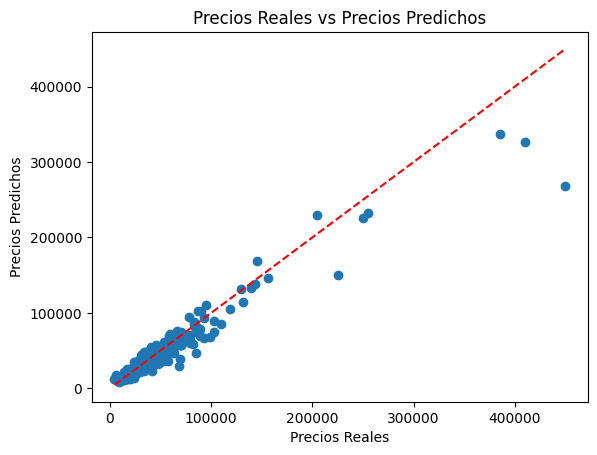

In [ ]:
# Realizar predicciones con el mejor modelo
y_pred = best_model.predict(X_test)

# Cambiar la forma de los arrays de precios predichos y reales
y_pred = y_pred.reshape(-1)
y_test = y_test.to_numpy().reshape(-1)  # Convierte y_test a un array de NumPy antes de cambiar su forma

# Crear un scatter plot para comparar los precios reales y predichos
plt.scatter(y_test, y_pred)
plt.xlabel("Precios Reales")
plt.ylabel("Precios Predichos")
plt.title("Precios Reales vs Precios Predichos")

# Dibujar una línea diagonal para representar la predicción perfecta
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')

plt.show()

63/63 [==============================] - 0s 2ms/step


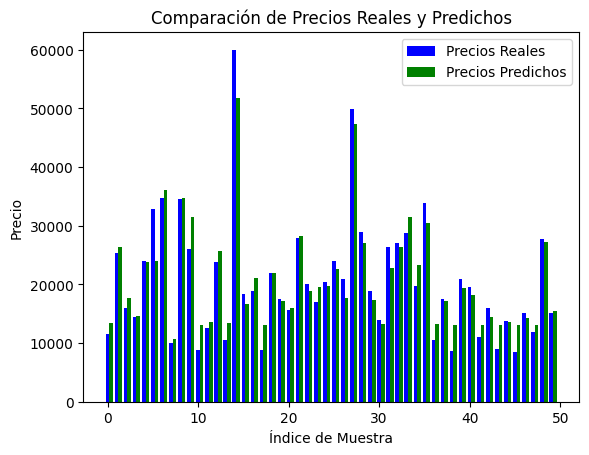

In [ ]:
# Realizar predicciones con el mejor modelo
y_pred = best_model.predict(X_test)

# Cambiar la forma de los arrays de precios predichos y reales
y_pred = y_pred.reshape(-1)
y_test = y_test.reshape(-1)

# Seleccionar una muestra de los datos (por ejemplo, los primeros 50)
num_samples = 50
indices = np.arange(num_samples)
y_test_sample = y_test[:num_samples]
y_pred_sample = y_pred[:num_samples]

# Crear un gráfico de barras con la muestra de datos
plt.bar(indices, y_test_sample, width=0.4, label='Precios Reales', color='b')
plt.bar(indices + 0.4, y_pred_sample, width=0.4, label='Precios Predichos', color='g')

plt.xlabel("Índice de Muestra")
plt.ylabel("Precio")
plt.title("Comparación de Precios Reales y Predichos")
plt.legend()

plt.show()

In [ ]:
# y_test = y_test.reshape(-1)
# y_pred = y_pred.to_numpy().reshape(-1)

In [ ]:
dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [ ]:
y_test

array([11495, 25299, 16000, ..., 26950, 14990, 12500])

In [ ]:
y_pred

array([13493.362, 26338.91 , 17672.734, ..., 28171.56 , 14257.217,
       13165.791], dtype=float32)

In [ ]:
X_test

,Color_COMMON.COLOR_BEIGE,Color_COMMON.COLOR_BLACK,Color_COMMON.COLOR_BLUE,Color_COMMON.COLOR_BROWN,Color_COMMON.COLOR_GARNET,Color_COMMON.COLOR_GRAY,Color_COMMON.COLOR_GREEN,Color_COMMON.COLOR_ORANGE,Color_COMMON.COLOR_PINK,Color_COMMON.COLOR_PURPLE,...,Body Type_BODY_TYPE_COUPE,Body Type_BODY_TYPE_FAMILIAR,Body Type_BODY_TYPE_MINIVAN,Body Type_BODY_TYPE_PICK_UP,Body Type_BODY_TYPE_SEDAN,KM,Year,Horsepower,Cubic Capacity,Doors
4535,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.077027,0.128269,1.0,0.529265,0.5
9652,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.162162,0.197830,1.0,0.142935,0.9
2649,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.067568,0.104252,1.0,0.600000,0.6
4553,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.020270,0.037182,1.0,0.235735,0.9
7525,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.094595,0.057641,1.0,0.188235,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4310,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.087838,0.111012,1.0,0.091318,0.7
6585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.054054,0.111012,1.0,0.473035,0.7
8105,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.094595,0.110834,1.0,0.198588,0.9
1073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.066216,0.104252,1.0,0.938412,0.2


In [ ]:
# Calcular el error absoluto medio (MAE)
mae = mean_absolute_error(y_test, y_pred)
print(f"Error absoluto medio (MAE): {mae:.2f}")

# Calcular el error cuadrático medio (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Error cuadrático medio (RMSE): {rmse:.2f}")

# Calcular el coeficiente de determinación (R^2)
r2 = r2_score(y_test, y_pred)
print(f"Coeficiente de determinación (R^2): {r2:.2f}")

Error absoluto medio (MAE): 2666.65
Error cuadrático medio (RMSE): 6323.63
Coeficiente de determinación (R^2): 0.93
